# ChromaDB Persistence and Performance

This notebook explores persistent storage and performance optimization in ChromaDB.

## Learning Objectives

By the end of this notebook, you will be able to:
- Set up persistent ChromaDB storage for production use
- Measure and optimize vector database performance
- Understand batch processing for efficient data ingestion
- Implement best practices for production deployments

## Why Persistence Matters

- **Business continuity** - Data survives system restarts and crashes
- **Cost effectiveness** - Avoid recomputing expensive embeddings
- **Production readiness** - Essential for real-world applications
- **Horizontal scaling** - Enables distributed architectures

## Setup: Install Required Libraries

In [ ]:
import os
os.environ['UV_LINK_MODE'] = 'copy'

!uv pip install accelerate==1.6.0 sentence-transformers==4.0.2

print("✓ Required libraries installed successfully!")

In [ ]:
import chromadb
from chromadb.utils import embedding_functions
import time
import numpy as np
import os

# Setup persistent storage path
db_path = "../scratch/chroma_db"
os.makedirs(db_path, exist_ok=True)

print("✓ Creating persistent ChromaDB client...")
client = chromadb.PersistentClient(path=db_path)

print("✓ Setting up embedding function...")
embedding_function = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name="all-MiniLM-L6-v2"
)

print(f"\n✓ Persistent storage configured!")
print(f"  Storage path: {db_path}")
print(f"  Embedding model: all-MiniLM-L6-v2")

In [4]:
# Helper function to display query results in a readable format
def display_results(results):
    print("\nResults:")
    for i, (doc, doc_id, metadata, distance) in enumerate(zip(
        results['documents'][0],
        results['ids'][0],
        results['metadatas'][0],
        results['distances'][0]
    )):
        print(f"{i+1}. Document: {doc}")
        print(f"   ID: {doc_id}")
        print(f"   Metadata: {metadata}")
        print(f"   Distance: {distance}")
        print()

## Creating and Using a Persistent Collection

Below we create a persistent collection and add sample documents to demonstrate basic operations.

In [5]:
# Create a new collection with our embedding function
print("Creating a persistent collection...")
persistent_collection = client.create_collection(
    name="persistent_docs",
    embedding_function=embedding_function
)

# Sample documents about data persistence
documents = [
    "This is a document that will be stored persistently",
    "Vector databases need to persist data for production use",
    "Data persistence ensures your embeddings survive restarts"
]

# Add documents with unique IDs
ids = ["pdoc1", "pdoc2", "pdoc3"]
persistent_collection.add(
    documents=documents,
    ids=ids
)

# Query the collection to verify it works
results = persistent_collection.query(
    query_texts=["persistent data storage"],
    n_results=1
)

display_results(results)

Creating a persistent collection...

Results:
1. Document: This is a document that will be stored persistently
   ID: pdoc1
   Metadata: None
   Distance: 0.7845402441433474



## Why Performance Matters

When working with vector databases in production, performance becomes critical for several reasons:

- **User Experience**: Slow query responses lead to poor user experiences
- **Resource Utilization**: Inefficient operations consume excessive computational resources
- **Scaling Challenges**: Performance problems compound as your data grows
- **Cost Implications**: In cloud environments, inefficient operations directly impact costs

Below we'll conduct a simple performance test with a larger dataset.

In [ ]:
print("=" * 80)
print("PERFORMANCE BENCHMARK")
print("=" * 80)

# Create collection for testing
collection = client.create_collection(name="performance_test", embedding_function=embedding_function)

# Generate synthetic documents
print("\nGenerating synthetic documents...")
words = ["AI", "machine", "learning", "vector", "database", "embedding", "neural",
         "network", "transformer", "data", "science", "engineering", "model"]

num_docs = 1000
documents = [" ".join(np.random.choice(words, size=np.random.randint(10, 20))) for _ in range(num_docs)]
ids = [f"perf_doc_{i}" for i in range(num_docs)]

# Benchmark document insertion
print(f"\nAdding {num_docs:,} documents in batches...")
start_time = time.time()
batch_size = 100
for i in range(0, num_docs, batch_size):
    collection.add(documents=documents[i:i+batch_size], ids=ids[i:i+batch_size])
add_time = time.time() - start_time

print(f"✓ Insertion complete!")
print(f"  Total time: {add_time:.2f}s")
print(f"  Throughput: {num_docs/add_time:.0f} docs/second")

# Benchmark queries
print(f"\nBenchmarking queries...")
query_times = []
for i in range(5):
    query = " ".join(np.random.choice(words, size=5))
    start = time.time()
    collection.query(query_texts=[query], n_results=10)
    query_times.append(time.time() - start)

print(f"✓ Query benchmark complete!")
print(f"  Average query time: {np.mean(query_times)*1000:.1f}ms")
print(f"  Min: {min(query_times)*1000:.1f}ms, Max: {max(query_times)*1000:.1f}ms")

## Performance Test Results

Let's visualize the query performance results with a chart:

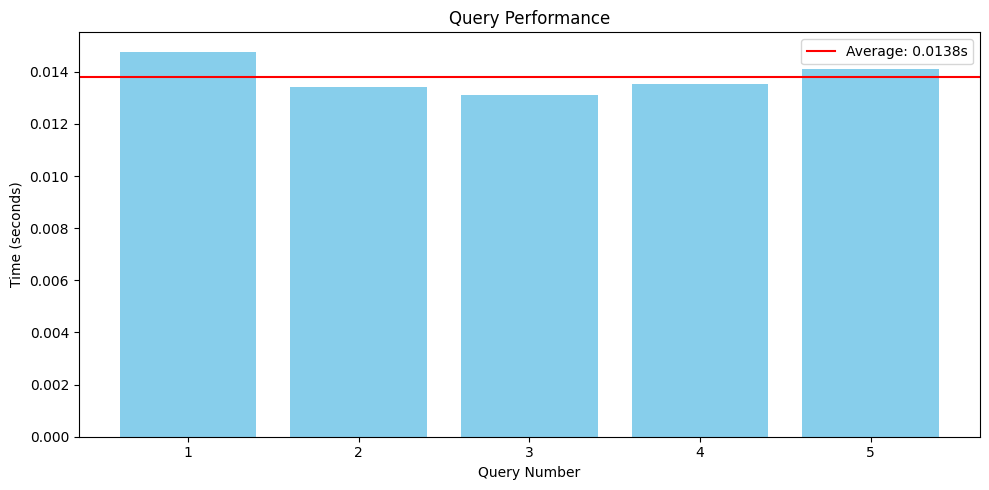

In [7]:
# Visualizing query performance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(range(1, num_queries + 1), query_times, color='skyblue')
plt.axhline(y=np.mean(query_times), color='r', linestyle='-', label=f'Average: {np.mean(query_times):.4f}s')
plt.xlabel('Query Number')
plt.ylabel('Time (seconds)')
plt.title('Query Performance')
plt.legend()
plt.tight_layout()
plt.show()

## Key Takeaways

1. **Persistence**: ChromaDB's PersistentClient provides an easy way to store vector embeddings on disk
2. **Performance**: 
   - Batch processing improves throughput when adding documents
   - Query performance remains fast even with 1000 documents (~13ms)
   - Consider monitoring performance as your collection size grows
3. **Production Readiness**:
   - Use persistent storage in production environments
   - Implement proper error handling
   - Consider scaling strategies for larger datasets

## Best Practices for Production Use

1. **Indexing Strategy**: For larger collections (>100K documents), consider using HNSW indexing (see next chapter for info).
   ```python
   collection = client.create_collection(
       name="large_collection",
       metadata={"hnsw:space": "cosine", "hnsw:construction_ef": 100, "hnsw:search_ef": 50}
   )
   ```

2. **Metadata Usage**: Enhance documents with metadata for filtering
   ```python
   collection.add(
       documents=["Document text..."],
       ids=["unique_id"],
       metadatas=[{"category": "finance", "date": "2025-04-01"}]
   )
   ```

3. **Hybrid Search**: Combine vector search with metadata filtering
   ```python
   results = collection.query(
       query_texts=["finance report"],
       where={"category": "finance"},
       n_results=5
   )
   ```

4. **Regular Backups**: Implement a backup strategy for your database directory